In [43]:
from datasets import load_dataset, ClassLabel, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score,accuracy_score
import evaluate
import numpy as np
import pandas as pd


In [44]:
sentiment = pd.read_csv('sample_cleaning.csv')
sentiment.head()

,comment,label
0,seluruh rakyat wajib demo ke dpr utk memaksa ...,Negative
1,ah bentar lgi nicke widyawati nyusul percaya...,Negative
2,ahirnya muntah juga mkn duit haram,Negative
3,mantap pak prabowo intel mulai kerja korupto...,Positive
4,sdh baik dirumah jadi ibu rumah tangga koq mau...,Negative


In [45]:
print(sentiment.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  400 non-null    object
 1   label    400 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB
None


In [46]:
sentiment.isna().sum()

comment    0
label      0
dtype: int64

In [47]:
sentiment_labels = ['Negative', 'Neutral', 'Positive']
sentiment = Dataset.from_pandas(sentiment)

In [48]:
sentiment = sentiment.cast_column('label', ClassLabel(names=sentiment_labels))
print(sentiment)

Casting the dataset: 100%|██████████| 400/400 [00:00<00:00, 48710.09 examples/s]

Dataset({
    features: ['comment', 'label'],
    num_rows: 400
})


In [49]:
train_val_split = sentiment.train_test_split(
    test_size=0.2,
    seed=42,
    stratify_by_column='label'
)
train_data = train_val_split['train']
val_data = train_val_split['test']

In [50]:
model_name = 'indolem/indobert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(comments):
    comment = comments['comment']
    return tokenizer(comment, truncation=True, max_length=512)

tokenized_train = train_data.map(tokenize, batched=True)
tokenized_val = val_data.map(tokenize, batched=True)

Map: 100%|██████████| 80/80 [00:00<00:00, 6556.80 examples/s]


In [51]:
print(tokenized_train)
print(tokenized_val)

Dataset({
    features: ['comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 320
})
Dataset({
    features: ['comment', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 80
})


In [52]:
tokenized_train = tokenized_train.rename_column('label', 'labels')
tokenized_val = tokenized_val.rename_column('label', 'labels')

tokenized_train = tokenized_train.remove_columns('comment')
tokenized_val = tokenized_val.remove_columns('comment')

tokenized_train.set_format('torch')
tokenized_val.set_format('torch')

In [53]:
print("Kolom tokenized_train:", tokenized_train.column_names)
print("Kolom tokenized_val:", tokenized_val.column_names)
print()
print(f"Jumlah data training: {len(tokenized_train)}")
print(f"Jumlah data validasi: {len(tokenized_val)}")

Kolom tokenized_train: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Kolom tokenized_val: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']

Jumlah data training: 320
Jumlah data validasi: 80


In [54]:
id_to_labels = {0: 'Positif', 1: 'Netral', 2: 'Negatif'}
label_to_id = {'Positif': 0, 'Netral': 1, 'Negatif': 2}

In [55]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id_to_labels,
    label2id=label_to_id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
sample = sentiment[0]
sample

{'comment': 'seluruh rakyat wajib demo ke dpr  utk memaksa dpr utk merevisi undang koruptor  rakyat menggugat',
 'label': 0}

In [57]:
data_collocator = DataCollatorWithPadding(tokenizer=tokenizer)

In [58]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)  # Convert logits to predicted class indices
    
    # Calculate metrics
    accuracy = accuracy_score(labels, preds).item()
    f1 = f1_score(labels, preds, average="weighted").item()
    precision = precision_score(labels, preds, average="weighted").item()
    recall = recall_score(labels, preds, average="weighted").item()
    
    # Return all metrics as a dictionary
    return {
        "accuracy": accuracy,
        "F1": f1,
        "precision": precision,
        "recall": recall
    }

In [59]:
# Configure training arguments
training_args = TrainingArguments(
    output_dir="tuned_indobert_sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="F1",  # Use F1 as the primary metric
    save_total_limit=1,
    logging_dir="./tuned_indobert_for-sentiment/logs",
    logging_strategy="epoch"
)

c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [60]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collocator,  # Ensure this is defined (e.g., DataCollatorWithPadding)
    compute_metrics=compute_metrics  # Use the corrected function
)

C:\Users\alber\AppData\Local\Temp\ipykernel_7644\2583125420.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [61]:
# 11. Jalankan training
trainer.train() 

# 12. Evaluasi akhir
print("Evaluasi pada data validasi:")
results = trainer.evaluate()
print(f"Hasil Evaluasi: {results}")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.814300,0.747208,0.737500,0.626079,0.543906,0.737500
2,0.744700,0.722386,0.737500,0.626079,0.543906,0.737500
3,0.724400,0.711192,0.737500,0.626079,0.543906,0.737500
4,0.694200,0.655331,0.750000,0.653830,0.713291,0.750000
5,0.648900,0.651294,0.737500,0.626079,0.543906,0.737500
6,0.620900,0.803349,0.737500,0.626079,0.543906,0.737500
7,0.535400,0.602306,0.750000,0.669669,0.663853,0.750000
8,0.466600,0.648831,0.775000,0.714645,0.751583,0.775000
9,0.401300,0.709336,0.775000,0.714645,0.751583,0.775000
10,0.340500,0.643240,0.787500,0.735085,0.740126,0.787500


c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alber\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\U

Evaluasi pada data validasi:


Hasil Evaluasi: {'eval_loss': 1.1180578470230103, 'eval_accuracy': 0.825, 'eval_F1': 0.806055493063367, 'eval_precision': 0.8197610294117649, 'eval_recall': 0.825, 'eval_runtime': 3.0078, 'eval_samples_per_second': 26.598, 'eval_steps_per_second': 3.325, 'epoch': 30.0}


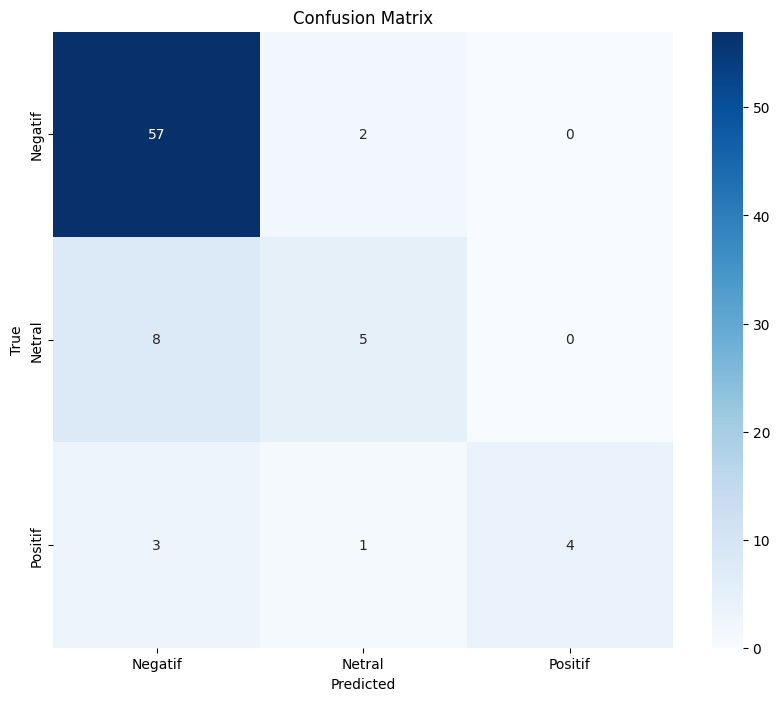

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt


predict = trainer.predict(tokenized_val)
logits = np.argmax(predict.predictions, axis=-1)
labels = predict.label_ids

id_to_labels = {0: "Negatif", 1: "Netral", 2: "Positif"}
xticklabels = [id_to_labels[i] for i in range(len(id_to_labels))]
yticklabels = [id_to_labels[i] for i in range(len(id_to_labels))]

cm = confusion_matrix(labels, logits)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()